In [26]:
from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
from scipy.io import wavfile
from scipy.interpolate import interp1d
from scipy.signal import butter, lfilter, freqz
import numpy as np
import seaborn as sns
import os

sns.set_theme()
sns.set_style("darkgrid")

In [27]:
fs, p = wavfile.read('sonido-presion/presion_segmento_3.wav')
fs, b = wavfile.read('sonido-presion/beta_segmento_3.wav')
fs, s_m = wavfile.read('sonido-presion/sonido_segmento_3.wav')
fs, s_s = wavfile.read('sonido-presion/simulacion_segmento_3.wav')

#normalizo
p = p.astype(np.float32)
s_m = s_m / max(s_m)
s_s = s_s[:-1] / max(s_s)
b = b[:-1]

In [28]:
print(len(s_m), len(s_s), len(b), len(t))

24472 24472 24472 24472


In [29]:
import json
t_silabas_file = open('sonido-presion/t_silabas.json') 

# returns JSON object as a list 
t_silabas = json.load(t_silabas_file) 
t_silabas = t_silabas['segmento_3']

In [4]:

dt = 1/fs
N  = len(p)
t = np.arange(0, N) * dt

print(f'frec muestreo: {fs} \n dt muestreo: {dt} \n tiempo total de medición {t[-1]} s')

frec muestreo: 44150 
 dt muestreo: 2.2650056625141562e-05 
 tiempo total de medición 0.5542695356738392 s


0


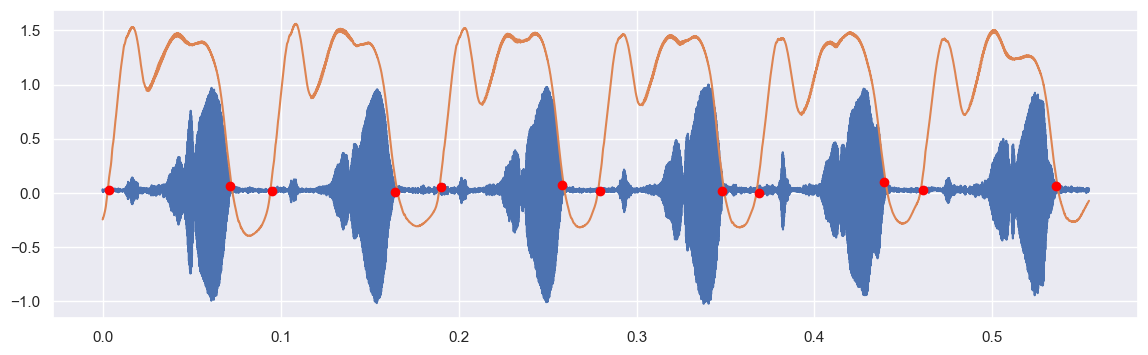

In [31]:

plt.figure(figsize=(14,4))
plt.plot(t,s_m)
plt.plot(t,b)


pulsos = {}
#ordeno los datos

print(len(pulsos))
for sil in t_silabas:
    ti = t_silabas[sil]['t_i']
    tf = t_silabas[sil]['t_f']
    si = s_m[t==ti]
    sf = s_m[t==tf]
    pulsos[sil] = {'t' : t[(t > ti ) & (t < tf )],
              's_m': s_m[(t > ti ) & (t < tf )],
              'b': b[(t > ti ) & (t < tf )]}
    plt.plot([ti,tf],[si,sf],'o', color = 'red')
#plt.axhline(0, color = 'black')
plt.show()

In [32]:
#sigma del sonido

sigma_m = np.std(s_m[b<0])

print(f'Desviación estandar de la señal de la simulacion: {sigma_m} ')




Desviación estandar de la señal de la simulacion: 0.011681933525586097 


### Criterio de fonación

Voy a decir que la señal está fonando si la distancia entre picos consecutivos es mayor a la distancia enre picos mínima de oscilación. Si es menor, digo que es ruido. 

Primero estudio las distancias entre picos.

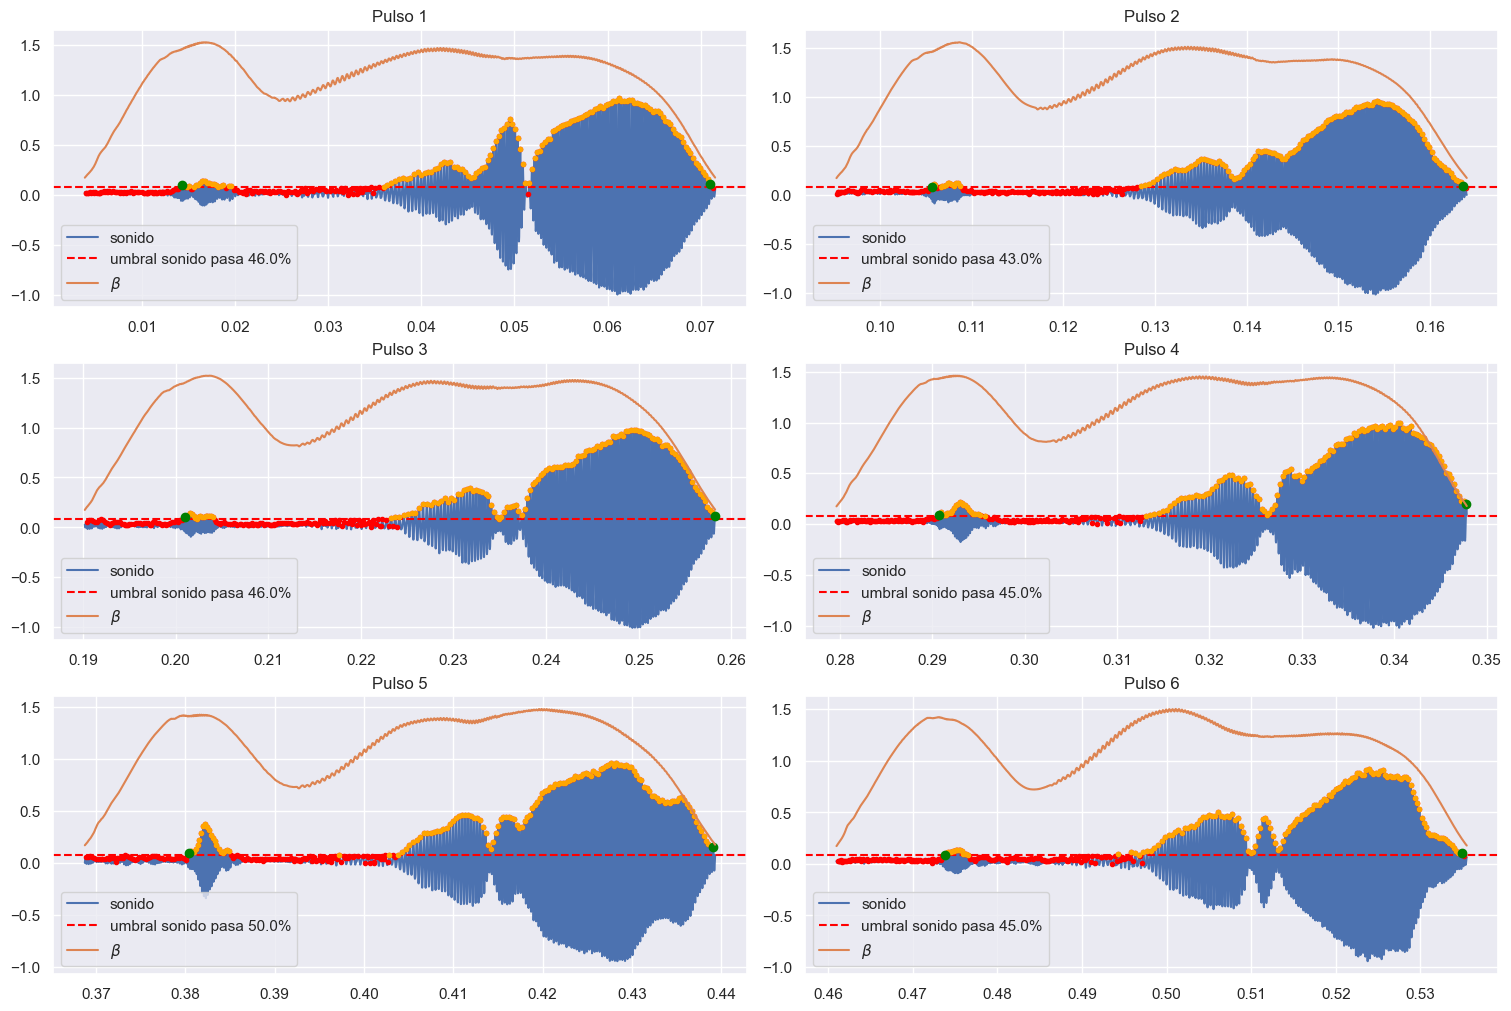

In [35]:
%matplotlib inline
fig, axes = plt.subplots(3, 2, figsize=(15,10), constrained_layout=True, sharey=False)
axs = axes.flatten()

pesos_umbral = [1, 1, 1.35, 1.2, 1.1, 1.1, 1.35, 1.1, .8, .8, .9, .7]
for i,ps in enumerate(pulsos):
    t_ = pulsos[ps]['t']
    s_m_ = pulsos[ps]['s_m']
    b_ = pulsos[ps]['b'] 
    picos_m, _ = signal.find_peaks(s_m_, height = 0 )  

    #guardo los indices de los picos
    pulsos[ps]['picos_m'] = picos_m
    
    #umbral de fonacion
    #umbral_m = max(s_m_[picos_m]) * 0.3 * pesos_umbral[i] #
    umbral_m = sigma_m * 7

    #indices de los picos que pasan el umbral
    index_fon_m = [p for p in picos_m if s_m_[p] > umbral_m]

    #fraccion de los picos que pasan el umbral
    fon_m = len(index_fon_m)/ len(picos_m)

    index_i = index_fon_m[0]
    index_f = index_fon_m[-1]
    pulsos[ps]['int_fon'] = [t_[index_i], t_[index_f]]
    #print(f'Porcentaje de fonación para el pulso {i+1}:')
    #print(f'Simulación: {fon_s * 100}%')
    #print(f'Medición: {fon_m * 100}%')
    axs[i].plot(t_,s_m_, label = 'sonido')
    axs[i].axhline( umbral_m,label = f'umbral sonido pasa {np.round(fon_m*100)}%', color = 'red', ls = '--')
    axs[i].plot(t_[picos_m], s_m_[picos_m], '.', color = 'red')
    axs[i].plot(t_[index_fon_m], s_m_[index_fon_m], '.', color = 'orange')
    axs[i].plot([t_[index_fon_m[0]], t_[index_fon_m[-1]]] , [s_m_[index_fon_m[0]], s_m_[index_fon_m[-1]]], 'o', color = 'green')
    axs[i].plot(t_,b_, label = r'$\beta$')
    axs[i].set_title(f'Pulso {i+1}')
    axs[i].legend()
plt.show()

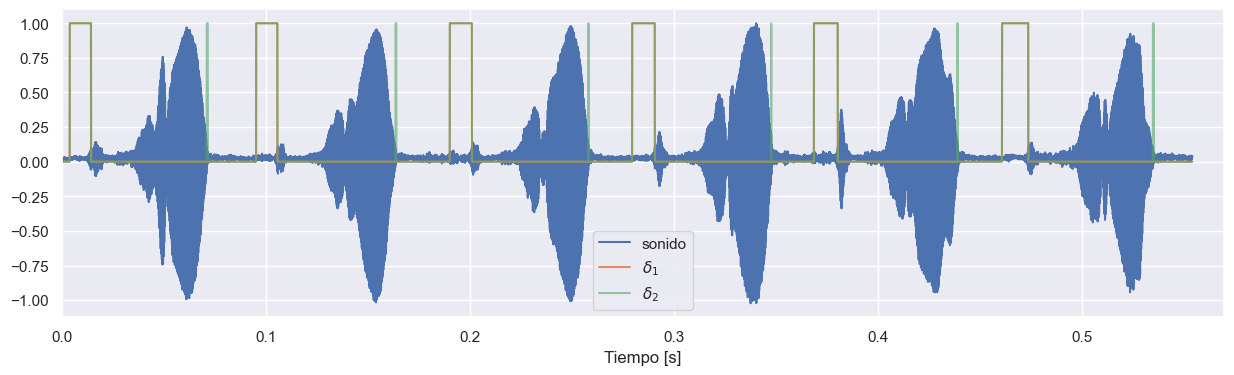

In [37]:
%matplotlib inline
delta1 = np.zeros(len(t))
delta2 = np.zeros(len(t))
t_fonacion = {ps: {'t_i': [] , 't_f': [] } for ps in pulsos}
for ps in pulsos:
    t_ = pulsos[ps]['t']
    b_ = pulsos[ps]['b']
    picos = pulsos[ps]['picos_m']

    #tiempo inicial de fonacion
    ti_fon = pulsos[ps]['int_fon'][0]
    tf_fon = pulsos[ps]['int_fon'][1]
    
    #tiempo inicial de la silaba
    ti_sil = t_[0]
    tf_sil = t_[-1]
    
    #construyo el delta
    delta1[(t >= ti_sil ) & (t <= ti_fon )] = 1
    delta2[(t >= ti_sil ) & (t <= ti_fon )] = 1
    delta2[(t >= tf_fon ) & (t <= tf_sil )] = 1

    t_fonacion[ps]['t_i'] = ti_fon
    t_fonacion[ps]['t_f'] = tf_fon
#delta[b<0] = 0
plt.figure(figsize = (15,4))
plt.xlabel('Tiempo [s]')
plt.plot(t,s_m/max(s_m), label = 'sonido')
plt.plot(t,delta1, label = r'$\delta_1$', alpha = .9)
plt.plot(t,delta2, label = r'$\delta_2$', alpha = .6)

plt.xlim(0, 0.57)
plt.legend()
plt.show()

In [38]:
import json

with open("sonido-presion/t_fon_segmento_3.json", "w") as outfile:
    json.dump(t_fonacion, outfile)


wavfile.write("sonido-presion/delta1_segmento_3.wav", fs, delta1.astype(np.float32))
wavfile.write("sonido-presion/delta2_segmento_3.wav", fs, delta2.astype(np.float32))

Intento con un filtro pasabajos: tal vez esa frecuencia del ruido subbyacente que el detector de picos no ve la puedo filtrar así?

In [21]:
for i,ps in enumerate(pulsos):
    t_ = pulsos[ps]['t']
    ti = t_[0]
    tf = t_[-1]
    print([ti,tf] ,',')

[np.float64(0.002740656851642129), np.float64(0.07297848244620611)] ,
[np.float64(0.09413363533408833), np.float64(0.16573046432616081)] ,
[np.float64(0.18892412231030578), np.float64(0.25977349943374856)] ,
[np.float64(0.2782106455266138), np.float64(0.3493318233295583)] ,
[np.float64(0.3673839184597961), np.float64(0.4409739524348811)] ,
[np.float64(0.4594337485843714), np.float64(0.5371913929784824)] ,
